# Libreries

In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:.4f}".format
#InteractiveShell.ast_node_interactivity = "last_expr"
np.set_printoptions(precision=6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['image.interpolation'] = 'spline16'

from scipy.stats import pearsonr
from scipy.stats import skewnorm
from scipy import stats


from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR






In [155]:
 #Load the dataset
dataset_path = 'D:\\Memorial UNi\\Capstone project\\New\\Processed 527 datapoints.xlsx'
data = pd.read_excel(dataset_path)



In [156]:
data.describe()

,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),S (%),Temp (°C),Pressure (bar),CO2 uptake (mmol/g)
count,527.0000,499.0000,317.0000,527.0000,527.0000,527.0000,527.0000,527.0000,527.0000,527.0000,527.0000
mean,1488.1502,0.8000,0.5168,76.3227,1.6841,3.2625,18.1733,0.1254,18.4630,0.8666,3.4535
std,728.6116,0.4482,0.2727,12.5913,1.5856,3.7123,11.6321,0.9308,11.0094,0.3112,1.5678
min,2.4800,0.0200,0.0400,40.4000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1000,0.3600
25%,955.5000,0.4800,0.3100,69.8300,0.0000,0.7150,9.9200,0.0000,0.0000,1.0000,2.3350
50%,1420.0000,0.6900,0.4800,79.1000,1.5000,2.1600,15.4300,0.0000,25.0000,1.0000,3.4600
75%,1960.0000,1.0300,0.6900,85.3300,2.4100,4.4500,22.9100,0.0000,25.0000,1.0000,4.3450
max,3337.0000,3.0900,1.2900,96.9600,6.0100,38.1500,54.0000,13.2000,30.0000,1.0132,8.2000


# Correlation Matrix

In [157]:
def corr_heatmap(dataset):
    correlation_matrix = data.corr()
    print(correlation_matrix)
    
    plt.figure(figsize=(12,10),dpi=200);
    sns.heatmap(np.round(dataset.corr(),3),cmap='YlGnBu', annot=True);
    plt.xticks(rotation = 30, horizontalalignment='right', fontsize= 18, fontname = "Times New Roman");
    plt.yticks(rotation = 0, fontsize= 18, fontname = "Times New Roman");
    plt.show();

                          Surface Area (m2/g)  Total Pore Volume(cm3/g)  \
Surface Area (m2/g)                    1.0000                    0.9100   
Total Pore Volume(cm3/g)               0.9100                    1.0000   
Micropore Volume (cm3/g)               0.7821                    0.6824   
C (%)                                  0.3414                    0.2759   
H (%)                                 -0.2430                   -0.2186   
N (%)                                 -0.1066                   -0.1520   
O (%)                                 -0.3171                   -0.2263   
S (%)                                 -0.0066                   -0.0066   
Temp (°C)                             -0.0796                   -0.1158   
Pressure (bar)                         0.1031                    0.1386   
CO2 uptake (mmol/g)                    0.2870                    0.2139   

                          Micropore Volume (cm3/g)   C (%)   H (%)   N (%)  \
Surface Area (m2/g)  

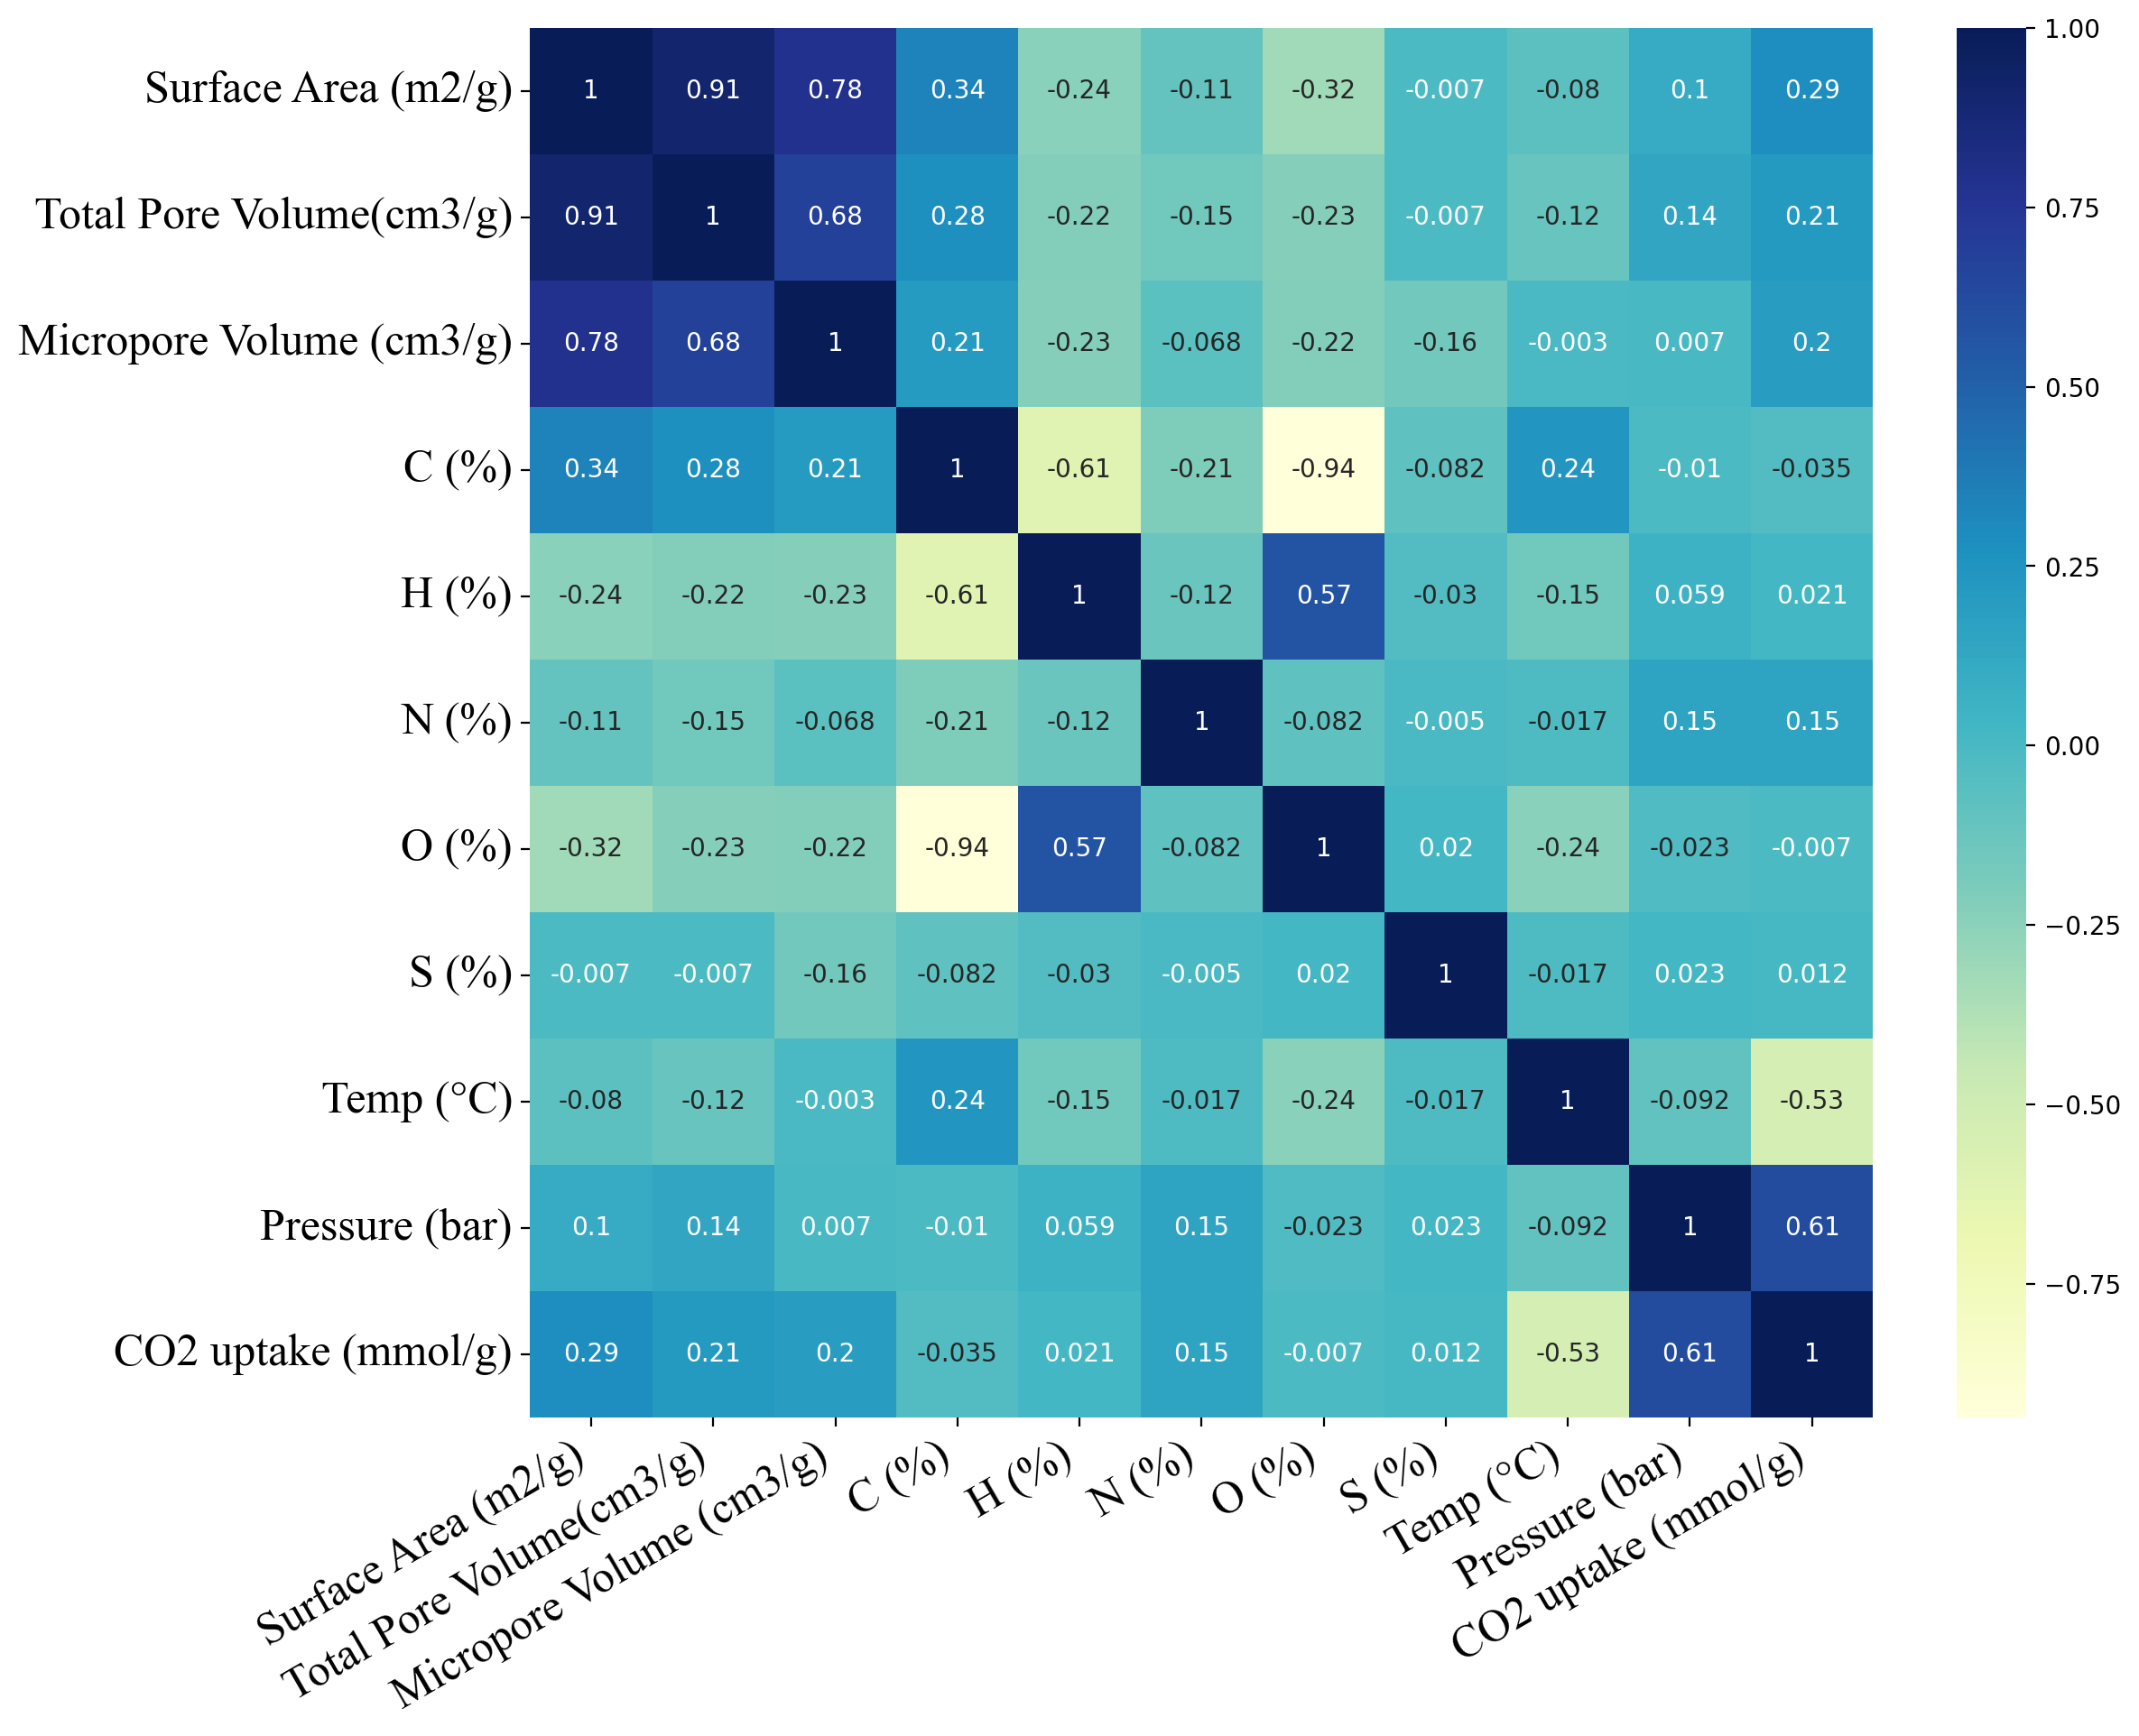

In [158]:
corr_heatmap(data)

# Missing Values

In [159]:
def missing_values(data):# Check for any null values
    has_null = data.isnull().values.any()
    print("Does the dataset contain any null values?", has_null)

    # Get a count of null values in each column
    null_counts = data.isnull().sum()
    print("Null values in each column:\n", null_counts)

In [160]:
missing_values(data)

Does the dataset contain any null values? True
Null values in each column:
 Surface Area (m2/g)           0
Total Pore Volume(cm3/g)     28
Micropore Volume (cm3/g)    210
C (%)                         0
H (%)                         0
N (%)                         0
O (%)                         0
S (%)                         0
Temp (°C)                     0
Pressure (bar)                0
CO2 uptake (mmol/g)           0
dtype: int64


# Handeling the Missing Data

In [161]:
# MPV and TPV prediction 
# Due to high correlation among the textural properties, we could create a simple model to predict and impute null values for MPV and TPV

def feature_impute(df_all, target):
    '''
    Evaluates different models to predict and impute null values.
    Models used were LR, RF, XGB, LGBM. 
    RF was superior (based on R2) so it was used.
    Args:
        df_all: DataFrame
        target: feature name to be imputed
    
    Returns:
        DataFrame with imputed data
    '''
    df_mv = df_all[["Surface Area (m2/g)", target]].copy()
    df_mv = df_mv.dropna()

    x = np.array(df_mv["Surface Area (m2/g)"]).reshape(-1,1)
    y = np.array(df_mv[target]).reshape(-1,1)

    x_train, x_test , y_train , y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

    print("LR:")
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    pred = lr.predict(x_test)
    scores = cross_val_score(lr, x_train, y_train , cv=3, scoring='r2')
    score = np.mean(scores)
    print("Train R2: %.3f (+/- %.3f) \n" %(score, scores.std()))
    print("Test R2: %.3f\n" %(r2_score(y_test, pred)))

    print("RF: ")
    rf = RandomForestRegressor(random_state =42)
    rf.fit(x_train, y_train)
    pred = rf.predict(x_test)
    scores = cross_val_score(rf, x_train, y_train , cv=3, scoring='r2')
    score = np.mean(scores)
    print("Train R2: %.3f (+/- %.3f) \n" %(score, scores.std()))
    print("Test R2: %.3f\n" %(r2_score(y_test, pred)))

    print("LGB: ")
    lg = LGBMRegressor(seed = 42)
    lg.fit(x_train, y_train)
    pred = lg.predict(x_test)
    scores = cross_val_score(lg, x_train, y_train , cv=3, scoring='r2')
    score = np.mean(scores)
    print("Train R2: %.3f (+/- %.3f) \n" %(score, scores.std()))
    print("Test R2: %.3f\n" %(r2_score(y_test, pred)))

    print("XGB: ")
    xg = XGBRegressor()
    xg.fit(x_train, y_train)
    pred = xg.predict(x_test)
    scores = cross_val_score(xg, x_train, y_train , cv=3, scoring='r2')
    score = np.mean(scores)
    print("Train R2: %.3f (+/- %.3f) \n" %(score, scores.std()))
    print("Test R2: %.3f\n" %(r2_score(y_test, pred)))
    
    # As RF is best:
    name = target + "_imputed"
    p = rf.predict(np.array(data["Surface Area (m2/g)"]).reshape(-1,1))
    data[name] = p
    return data

In [162]:
feature_impute(data, "Total Pore Volume(cm3/g)")
feature_impute(data, "Micropore Volume (cm3/g)")

LR:
Train R2: 0.832 (+/- 0.046) 

Test R2: 0.801

RF: 
Train R2: 0.847 (+/- 0.025) 

Test R2: 0.926

LGB: 
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 399, number of used features: 1
[LightGBM] [Info] Start training from score 0.821704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),S (%),Temp (°C),Pressure (bar),CO2 uptake (mmol/g),Total Pore Volume(cm3/g)_imputed,Micropore Volume (cm3/g)_imputed
0,1281.6000,0.7100,0.3200,69.2200,3.9900,0.0800,26.3000,0.4000,25,1.0000,2.6250,0.5625,0.3804
1,1012.6000,0.5600,0.2200,64.8300,3.6400,0.3800,30.7700,0.3800,25,1.0000,2.5864,0.5385,0.2800
2,1408.8000,0.8300,0.3600,72.4100,3.6300,0.0100,23.5900,0.3700,25,1.0000,2.9205,0.6658,0.4069
3,1403.9000,0.8500,0.3300,69.5100,4.3500,0.7600,24.9400,0.4400,25,1.0000,2.4386,0.8071,0.4030
4,841.3000,0.3600,NaN,68.4300,0.0000,31.0900,0.4800,0.0000,25,1.0000,3.2300,0.4658,0.3049
...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,2230.0000,1.0300,0.8900,86.5000,0.0000,0.4000,11.9000,0.0000,25,0.1500,0.9800,1.0531,0.8467
523,1950.0000,0.8800,0.7200,84.8000,0.0000,0.4000,11.9000,0.0000,25,0.1500,1.1400,0.9402,0.6474
524,1230.0000,0.9000,NaN,66.4100,0.0000,8.3300,25.2600,4.0000,0,1.0000,5.1400,0.8453,0.2292
525,2380.0000,1.6400,NaN,77.9300,0.0000,4.9400,17.1300,1.1200,0,1.0000,5.4500,1.4435,0.6988


In [163]:
data["Total Pore Volume(cm3/g)"] = data["Total Pore Volume(cm3/g)"].fillna(data["Total Pore Volume(cm3/g)_imputed"])
data["Micropore Volume (cm3/g)"] = data["Micropore Volume (cm3/g)"].fillna(data["Micropore Volume (cm3/g)_imputed"])
data["Temp (°C)"]= data["Temp (°C)"].fillna(25)

In [164]:
# drop unrequired featues
data_1 = data.drop(["S (%)",'Total Pore Volume(cm3/g)_imputed','Micropore Volume (cm3/g)_imputed'], axis = 1)

In [165]:
#Processed dataset
data_1.head()

,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),Temp (°C),Pressure (bar),CO2 uptake (mmol/g)
0,1281.6000,0.7100,0.3200,69.2200,3.9900,0.0800,26.3000,25,1.0000,2.6250
1,1012.6000,0.5600,0.2200,64.8300,3.6400,0.3800,30.7700,25,1.0000,2.5864
2,1408.8000,0.8300,0.3600,72.4100,3.6300,0.0100,23.5900,25,1.0000,2.9205
3,1403.9000,0.8500,0.3300,69.5100,4.3500,0.7600,24.9400,25,1.0000,2.4386
4,841.3000,0.3600,0.3049,68.4300,0.0000,31.0900,0.4800,25,1.0000,3.2300


# RPCs (regular porous carbons)

In [166]:
# The first 194 datapoints in the excel sheet belong to RPC subset
df_RPC = data_1[:195]
df_RPC.head()

,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),Temp (°C),Pressure (bar),CO2 uptake (mmol/g)
0,1281.6000,0.7100,0.3200,69.2200,3.9900,0.0800,26.3000,25,1.0000,2.6250
1,1012.6000,0.5600,0.2200,64.8300,3.6400,0.3800,30.7700,25,1.0000,2.5864
2,1408.8000,0.8300,0.3600,72.4100,3.6300,0.0100,23.5900,25,1.0000,2.9205
3,1403.9000,0.8500,0.3300,69.5100,4.3500,0.7600,24.9400,25,1.0000,2.4386
4,841.3000,0.3600,0.3049,68.4300,0.0000,31.0900,0.4800,25,1.0000,3.2300


### Creating Sample dataset from RPCs

In [167]:
# Randomly selecting 80 samples from df_RPC
df_RPC_sample = df_RPC.sample(n=80, random_state=42)

# Displaying the first 5 rows of the sampled dataset
df_RPC_sample.head()

,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),Temp (°C),Pressure (bar),CO2 uptake (mmol/g)
138,849.0000,0.5000,0.3100,54.9000,0.0000,0.5300,44.5700,0,1.0000,3.7000
16,1692.0000,0.7100,0.6800,94.5100,0.5800,1.5100,0.0000,25,0.1500,1.2000
155,1957.0000,0.7900,0.0966,71.2000,1.9700,1.9700,19.5700,25,1.0000,3.4500
96,1543.0000,0.7100,0.6100,66.5600,2.9900,0.8600,29.5900,0,1.0000,5.0600
68,660.0000,0.2800,0.2400,83.4800,0.0100,3.5300,12.9800,25,0.1500,0.7400


In [168]:
# Step 1: Split the Data (for RPC subset)
X = df_RPC_sample.drop(columns='CO2 uptake (mmol/g)')  # Replace 'CO2 uptake (mmol/g)' with the actual target column name
y = df_RPC_sample['CO2 uptake (mmol/g)']  # Replace 'CO2 uptake (mmol/g)' with the actual target column name

X_RPC_train, X_RPC_test, y_RPC_train, y_RPC_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [169]:
# Use the original training data
org_train_RPC_samp_data = pd.concat([X_RPC_train, y_RPC_train], axis=1)

# Convert the dataframe to a numpy array
X_RPC_data = org_train_RPC_samp_data.values

### Creating Synthetic Dataset using GAN From RPCs Sample 

In [170]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler




# Scale the data
scaler = MaxAbsScaler()
X_data = scaler.fit_transform(X_RPC_data)

# Set the random seed for reproducibility
torch.manual_seed(111)

# Define the Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(10, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(128, momentum=0.8),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(64, momentum=0.8),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(32, momentum=0.8),
            nn.Linear(32, 10),  # Adjusted to 9 features
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(10, 64),  # Adjusted to 9 features
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

# Training function for the GAN
def train_gan(epochs, X_data, batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    adversarial_loss = nn.BCELoss()

    X_data = torch.tensor(X_data, dtype=torch.float).to(device)

    for epoch in range(epochs):
        for _ in range(X_data.size(0) // batch_size):
            # Train Discriminator
            idx = np.random.randint(0, X_data.size(0), batch_size)
            real_imgs = X_data[idx]

            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)

            optimizer_D.zero_grad()
            z = torch.randn(batch_size, 10).to(device)
            gen_imgs = generator(z)
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)
            g_loss.backward()
            optimizer_G.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs} [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}]")

    return generator

# Train the GAN
generator = train_gan(epochs=10000, X_data=X_data, batch_size=32)

# Number of samples to generate
num_samples = 50

# Generate more samples
def generate_samples(generator, num_samples, latent_dim=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    z = torch.randn(num_samples, latent_dim).to(device)
    gen_imgs = generator(z).detach().cpu().numpy()
    return gen_imgs

generated_data = generate_samples(generator, num_samples=num_samples)

# Convert the generated data to a DataFrame
generated_RPC_df = pd.DataFrame(generated_data, columns=org_train_RPC_samp_data.columns)



# Display the first few rows of the generated data
print(generated_RPC_df.head())


Epoch 1/10000 [D loss: 0.696614] [G loss: 0.638330]
Epoch 101/10000 [D loss: 0.575739] [G loss: 0.779186]
Epoch 201/10000 [D loss: 0.619223] [G loss: 0.839021]
Epoch 301/10000 [D loss: 0.644365] [G loss: 0.854135]
Epoch 401/10000 [D loss: 0.629473] [G loss: 0.848610]
Epoch 501/10000 [D loss: 0.659753] [G loss: 0.771341]
Epoch 601/10000 [D loss: 0.655196] [G loss: 0.743009]
Epoch 701/10000 [D loss: 0.656504] [G loss: 0.732185]
Epoch 801/10000 [D loss: 0.656497] [G loss: 0.740268]
Epoch 901/10000 [D loss: 0.661513] [G loss: 0.715240]
Epoch 1001/10000 [D loss: 0.661488] [G loss: 0.734660]
Epoch 1101/10000 [D loss: 0.601602] [G loss: 0.813777]
Epoch 1201/10000 [D loss: 0.624875] [G loss: 0.783148]
Epoch 1301/10000 [D loss: 0.629201] [G loss: 0.735665]
Epoch 1401/10000 [D loss: 0.624051] [G loss: 0.786834]
Epoch 1501/10000 [D loss: 0.618653] [G loss: 0.784761]
Epoch 1601/10000 [D loss: 0.586538] [G loss: 0.841707]
Epoch 1701/10000 [D loss: 0.563540] [G loss: 0.908543]
Epoch 1801/10000 [D lo

In [171]:
gan_RPC_df = generated_RPC_df

gan_RPC_df.head()

,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),Temp (°C),Pressure (bar),CO2 uptake (mmol/g)
0,0.3262,0.3296,0.1345,0.6968,0.4056,0.0126,0.4615,0.9957,0.9954,0.3613
1,0.4210,0.3414,0.4318,0.8534,0.2411,0.0690,0.4312,0.9958,0.1648,0.1453
2,0.4005,0.3732,0.2420,0.8486,0.2685,-0.0092,0.5256,0.9960,0.9952,0.5724
3,0.7300,0.6924,0.6293,0.9420,0.1565,-0.0586,0.1079,0.9971,0.9861,0.4537
4,0.4996,0.4530,0.3437,0.8665,0.1054,0.0059,0.4046,0.9974,0.9815,0.5065


## Predection and stacking original  RPCs Sample train data

In [172]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

np.random.seed(123)
# Initialize models
xgb_model = XGBRegressor(random_state=42)
lgb_model = LGBMRegressor(random_state=42)
gbr_model = GradientBoostingRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
svr_model = SVR()

# Train models on the training data
xgb_model.fit(X_RPC_train, y_RPC_train)
lgb_model.fit(X_RPC_train, y_RPC_train)
gbr_model.fit(X_RPC_train, y_RPC_train)
rf_model.fit(X_RPC_train, y_RPC_train)
svr_model.fit(X_RPC_train, y_RPC_train)

# Generate predictions on the training data
y_pred_xgb = xgb_model.predict(X_RPC_train)
y_pred_lgb = lgb_model.predict(X_RPC_train)
y_pred_gbr = gbr_model.predict(X_RPC_train)
y_pred_rf = rf_model.predict(X_RPC_train)
y_pred_svr = svr_model.predict(X_RPC_train)

# Combine predictions into a new DataFrame
stacking_train_RPC_data = pd.DataFrame({
    'y_pred_xgb': y_pred_xgb,
    'y_pred_lgb': y_pred_lgb,
    'y_pred_gbr': y_pred_gbr,
    'y_pred_rf': y_pred_rf,
    'y_pred_svr': y_pred_svr,
    'y_true': y_RPC_train
})

stacking_train_RPC_data




[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 9
[LightGBM] [Info] Start training from score 3.134382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

,y_pred_xgb,y_pred_lgb,y_pred_gbr,y_pred_rf,y_pred_svr,y_true
137,6.3001,5.3055,6.1926,5.8953,3.3421,6.3000
173,6.2395,5.7918,6.2178,6.2236,2.8664,6.2400
136,4.0005,4.4600,4.0314,4.0039,3.0922,4.0000
135,2.2503,2.6746,2.2700,2.0280,3.2592,2.2500
111,1.1006,1.2077,1.1106,1.1137,3.1735,1.1000
...,...,...,...,...,...,...
123,6.0389,4.9475,5.9515,5.7366,3.3577,6.0400
31,3.4193,3.1566,3.3964,3.4841,3.3196,3.4200
2,2.9214,3.0648,2.9948,3.1438,3.3348,2.9205
164,1.2777,1.1034,1.2263,1.2300,3.3491,1.2800


## Predection and stacking original  RPCs Sample test data

In [173]:

np.random.seed(123)
# Define the input features (predicted values) and the target for stacking
X_stacking = stacking_train_RPC_data[['y_pred_xgb', 'y_pred_lgb', 'y_pred_gbr', 'y_pred_rf', 'y_pred_svr']]
y_stacking = stacking_train_RPC_data['y_true']

# Initialize and train the stacking model (SVM)
stacking_model = SVR()
stacking_model.fit(X_stacking, y_stacking)

# Make predictions on the test set using the trained models
y_test_pred_xgb = xgb_model.predict(X_RPC_test)
y_test_pred_lgb = lgb_model.predict(X_RPC_test)
y_test_pred_gbr = gbr_model.predict(X_RPC_test)
y_test_pred_rf = rf_model.predict(X_RPC_test)
y_test_pred_svr = svr_model.predict(X_RPC_test)

# Combine test set predictions into a DataFrame for stacking
stacking_test_data = pd.DataFrame({
    'y_pred_xgb': y_test_pred_xgb,
    'y_pred_lgb': y_test_pred_lgb,
    'y_pred_gbr': y_test_pred_gbr,
    'y_pred_rf': y_test_pred_rf,
    'y_pred_svr': y_test_pred_svr
})

# Predict the final output using the stacking model
y_test_final_pred = stacking_model.predict(stacking_test_data)

# Evaluate the performance of the stacking model
mse = mean_squared_error(y_RPC_test, y_test_final_pred)
print(f'Mean Squared Error of the Stacking Model: {mse}')

Mean Squared Error of the Stacking Model: 0.17884184110523565


In [174]:
# Function to print the metrics for each model
def print_metrics_RPC(model_name, y_train_true, y_train_pred, y_test_true, y_test_pred, tolerance=0.1):
    # Calculate R2 on training data
    r2_train = r2_score(y_train_true, y_train_pred)
    
    # Calculate R2 on test data
    r2_test = r2_score(y_test_true, y_test_pred)
    
    # Calculate Mean Squared Error (MSE) on test data
    mse_test = mean_squared_error(y_test_true, y_test_pred)
    
    # Calculate Root Mean Squared Error (RMSE) on test data
    rmse_test = np.sqrt(mse_test)
    
    # Calculate Training Accuracy (within tolerance)
    correct_train_predictions = np.sum(np.abs(y_train_true - y_train_pred) <= tolerance * np.abs(y_train_true))
    training_accuracy = correct_train_predictions / len(y_train_true) * 100
    
    # Display the metrics
    print(f"Metrics for {model_name} Model:")
    print(f"Training R2: {r2_train}")
    print(f"Training Accuracy: {training_accuracy:.2f}%")
    print(f"Test R2: {r2_test}")
    print(f"Test Set MSE: {mse_test}")
    print(f"Test Set RMSE: {rmse_test}")
    print()
    
    return training_accuracy

## Predection and stacking original  RPCs Sample GAN data

In [176]:
# Separate the features and target in the GAN-generated data
X_GAN = gan_RPC_df.drop(columns='CO2 uptake (mmol/g)')  # Replace with actual target column name
Y_GAN = gan_RPC_df['CO2 uptake (mmol/g)']  # Replace with actual target column name

np.random.seed(123)
# Generate predictions using the individual models on X_GAN
y_gan_pred_xgb = xgb_model.predict(X_GAN)
y_gan_pred_lgb = lgb_model.predict(X_GAN)
y_gan_pred_gbr = gbr_model.predict(X_GAN)
y_gan_pred_rf = rf_model.predict(X_GAN)
y_gan_pred_svr = svr_model.predict(X_GAN)

# Combine these predictions into a DataFrame
X_GAN_stacking = pd.DataFrame({
    'y_pred_xgb': y_gan_pred_xgb,
    'y_pred_lgb': y_gan_pred_lgb,
    'y_pred_gbr': y_gan_pred_gbr,
    'y_pred_rf': y_gan_pred_rf,
    'y_pred_svr': y_gan_pred_svr
})


In [177]:
# Apply the trained SVM stacking model to the GAN data
Y_GAN_stacked = stacking_model.predict(X_GAN_stacking)

Y_GAN_stacked

array([2.494978, 1.399106, 2.783641, 3.500179, 3.190683, 3.279916,
       3.490423, 2.39842 , 1.29445 , 3.508175, 3.499184, 3.483241,
       2.995738, 2.803724, 3.512094, 3.505789, 3.512794, 3.192866,
       2.474373, 3.496618, 1.494456, 2.267895, 2.611332, 3.190326,
       1.241362, 3.496618, 3.410458, 3.493169, 1.304294, 1.273763,
       1.265105, 1.273906, 2.947257, 1.305577, 3.504966, 3.516206,
       3.497717, 1.306904, 3.273536, 1.495128, 3.488169, 2.781232,
       3.405809, 3.505879, 1.253023, 1.389658, 3.498765, 3.186238,
       3.543297, 3.428114])

## Combine RPCs Training Data Creation

In [178]:
# Combine X_GAN and Y_GAN_stacked into a new DataFrame
gan_stacked_df = pd.DataFrame(X_GAN)
gan_stacked_df['CO2 uptake (mmol/g)'] = Y_GAN_stacked  # Replace with actual target column name

# Combine the original training data with the GAN-stacked data
combined_training_data = pd.concat([org_train_RPC_samp_data, gan_stacked_df], axis=0)

combined_training_data.head()


,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),Temp (°C),Pressure (bar),CO2 uptake (mmol/g)
137,1122.0000,0.5900,0.5000,84.7000,0.0000,0.8700,14.4300,0.0000,1.0000,6.3000
173,2695.0000,1.1400,1.1100,82.7000,1.8000,0.4500,15.0500,0.0000,1.0000,6.2400
136,637.0000,0.3500,0.2500,84.2000,0.0000,0.7600,15.0400,0.0000,1.0000,4.0000
135,1671.0000,0.6700,0.5900,47.1000,5.2900,0.6600,46.3900,0.0000,0.1500,2.2500
111,1830.0000,0.7800,0.6700,83.4000,0.9000,0.0000,15.7000,25.0000,0.1500,1.1000


## Applying Mechine Learning Models on Combine RPCs Training Data

In [179]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np



# Separate the features and target from the combined training data
X_combined = combined_training_data.drop(columns='CO2 uptake (mmol/g)')  # Replace with actual target column name
y_combined = combined_training_data['CO2 uptake (mmol/g)']  # Replace with actual target column name


np.random.seed(123)
# Retrain models on the combined dataset
xgb_model.fit(X_combined, y_combined)
lgb_model.fit(X_combined, y_combined)
gbr_model.fit(X_combined, y_combined)

# Predict on the training data
y_train_pred_comb_xgb = xgb_model.predict(X_combined)
y_train_pred_comb_lgb = lgb_model.predict(X_combined)
y_train_pred_comb_gbr = gbr_model.predict(X_combined)



# Calculate and print metrics for each model, also store the training accuracy
training_accuracy_xgb = print_metrics_RPC("XGBoost", y_combined, y_train_pred_comb_xgb, y_RPC_test, y_test_pred_xgb)
training_accuracy_lgb = print_metrics_RPC("LightGBM", y_combined, y_train_pred_comb_xgb, y_RPC_test, y_test_pred_lgb)
training_accuracy_gbr = print_metrics_RPC("Gradient Boosting Regressor", y_combined, y_train_pred_comb_xgb, y_RPC_test, y_test_pred_gbr)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 114, number of used features: 9
[LightGBM] [Info] Start training from score 2.956728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to generate a scatter plot with joint histograms
def generate_plot(y_train_true, y_train_pred, y_test_true, y_test_pred, model_name):
    g = sns.JointGrid(x=y_test_true, y=y_test_pred)
    
    # Plot training data predictions
    sns.scatterplot(x=y_train_true, y=y_train_pred, s=100, color='red', ax=g.ax_joint)
    
    # Plot test data predictions
    sns.scatterplot(x=y_test_true, y=y_test_pred, s=100, color='green', ax=g.ax_joint)
    
    # Add regression line for test data
    sns.regplot(x=y_test_true, y=y_test_pred, ax=g.ax_joint)
    
    # Set limits
    plt.ylim(0, 7)
    plt.xlim(0, 7)
    
    # Set labels
    g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", fontsize=14, fontname='Times New Roman')
    
    # Add histograms on the top
    sns.histplot(x=y_train_true, ax=g.ax_marg_x, color='red')
    sns.histplot(x=y_test_true, ax=g.ax_marg_x, color='green')
    
    # Add legend
    g.ax_marg_x.legend(["Train", "Test"])
    
    # Title for the plot
    plt.suptitle(f'{model_name} Model: Actual vs Predicted CO\u2082 Adsorbed', y=1.02, fontsize=16)
    
    plt.show()

# Outputs

**Original RPC sample Data**

In [ ]:
print_metrics_RPC("XGB (Original RPCs sample Data)", y_RPC_train, xgb_model.predict(X_RPC_train), y_RPC_test, y_test_pred_xgb)

# Print metrics for LGB Model trained on original data
print_metrics_RPC("LGB (Original RPCs sample Data)", y_RPC_train, lgb_model.predict(X_RPC_train),  y_RPC_test, y_test_pred_lgb)

# Print metrics for GBR Model trained on original data
print_metrics_RPC("GBR (Original RPCs sample Data)", y_RPC_train, gbr_model.predict(X_RPC_train),  y_RPC_test, y_test_pred_gbr)

In [ ]:
# Generate plot for XGB model with original data
generate_plot(y_RPC_train, xgb_model.predict(X_RPC_train), y_RPC_test, y_test_pred_xgb, "XGBoost (Original RPCs Data)")
# Generate plot for LGB model with original data
generate_plot(y_RPC_train, lgb_model.predict(X_RPC_train), y_RPC_test, y_test_pred_lgb, "LGBMRegressor (Original RPCs Data)")
# Generate plot for GBR model with original data
generate_plot(y_RPC_train, gbr_model.predict(X_RPC_train), y_RPC_test, y_test_pred_gbr, "GBR (Original RPCs Data)")




**Combine RPC trainig Data**

In [180]:
# Print metrics for XGB Model
print_metrics_RPC("XGB (Combine RPC trainig Data)", y_combined, y_train_pred_comb_xgb, y_RPC_test, y_test_pred_xgb)
# Print metrics for LGB Model
print_metrics_RPC("LGB (Combine RPC trainig Data)", y_combined, y_train_pred_comb_lgb, y_RPC_test, y_test_pred_lgb)
# Print metrics for GBR Model
print_metrics_RPC("GBR (Combine RPC trainig Data)", y_combined, y_train_pred_comb_gbr, y_RPC_test, y_test_pred_gbr)



Metrics for XGB Model:
Training R2: 0.9999993258274902
Training Accuracy: 100.00%
Test R2: 0.8647805117113578
Test Set MSE: 0.2884615687415431
Test Set RMSE: 0.5370861837187242

Metrics for LGB Model:
Training R2: 0.9497509451488501
Training Accuracy: 64.91%
Test R2: 0.8651551059179148
Test Set MSE: 0.28766245292005566
Test Set RMSE: 0.5363417314735593

Metrics for GBR Model:
Training R2: 0.9977368250923099
Training Accuracy: 98.25%
Test R2: 0.9100014932062954
Test Set MSE: 0.19199237316067455
Test Set RMSE: 0.43816934301782745



98.24561403508771

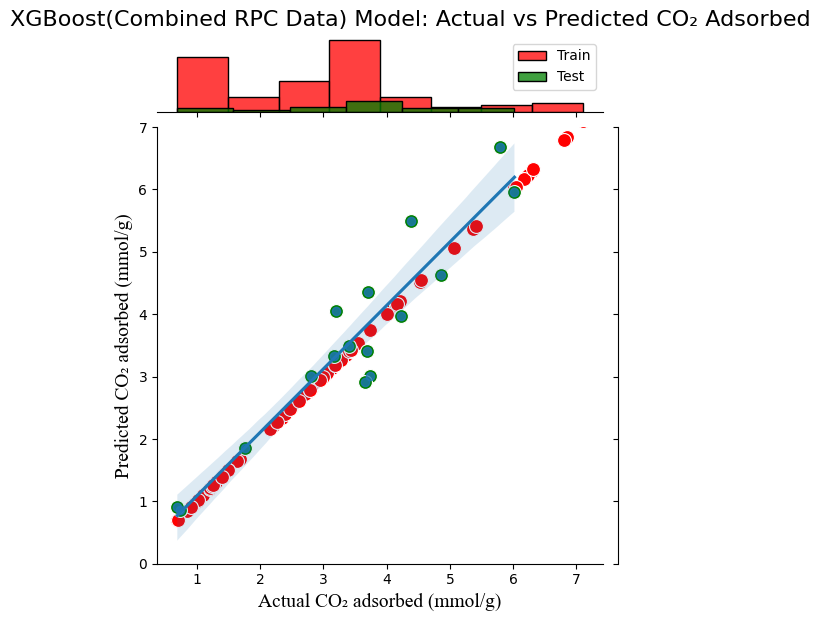

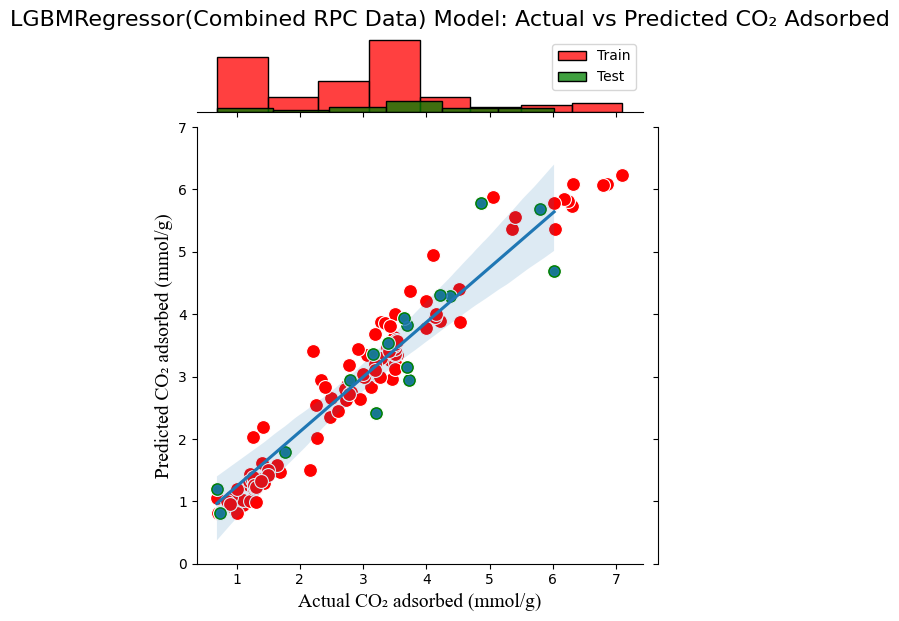

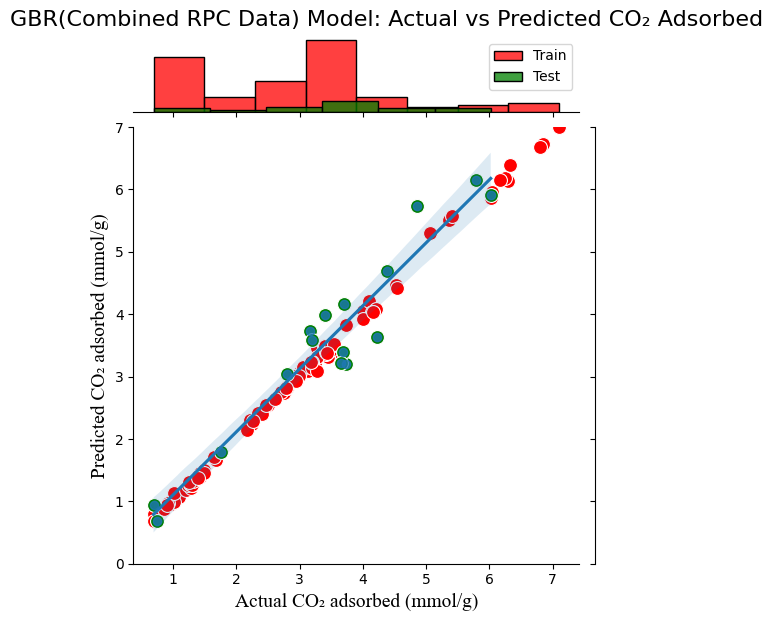

In [202]:


# Example usage for XGBoost
generate_plot(y_combined, y_train_pred_comb_xgb, y_RPC_test, y_test_pred_xgb, "XGBoost(Combined RPC Data)")

# Example usage for LGBMRegressor model
generate_plot(y_combined, y_train_pred_comb_lgb, y_RPC_test, y_test_pred_lgb, "LGBMRegressor(Combined RPC Data)")

# Example usage for GBR
generate_plot(y_combined, y_train_pred_comb_gbr, y_RPC_test, y_test_pred_gbr, "GBR(Combined RPC Data)")


# HDPCs (heteroatom-doped porous carbons)

In [184]:
#The HDPC dataset starts from the 195th row in the excel sheet

df_HDPC = data_1[195:]
df_HDPC.tail()

,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),Temp (°C),Pressure (bar),CO2 uptake (mmol/g)
522,2230.0000,1.0300,0.8900,86.5000,0.0000,0.4000,11.9000,25,0.1500,0.9800
523,1950.0000,0.8800,0.7200,84.8000,0.0000,0.4000,11.9000,25,0.1500,1.1400
524,1230.0000,0.9000,0.2292,66.4100,0.0000,8.3300,25.2600,0,1.0000,5.1400
525,2380.0000,1.6400,0.6988,77.9300,0.0000,4.9400,17.1300,0,1.0000,5.4500
526,2700.0000,1.3300,1.1064,80.9500,0.0000,3.4500,15.6000,0,1.0000,4.2700


## Creating Sample dataset from HDPCs

In [185]:
# Randomly selecting 80 samples from df_RPC
df_HDPC_sample = df_HDPC.sample(n=80, random_state=42)

# Displaying the first 5 rows of the sampled dataset
df_HDPC_sample.head()

,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),Temp (°C),Pressure (bar),CO2 uptake (mmol/g)
220,660.0000,0.4200,0.3300,57.8900,2.7100,4.3100,35.0900,25,1.0000,2.0400
512,1210.0000,0.4800,0.3900,78.6000,0.0000,1.7000,17.6000,25,1.0000,3.3900
268,516.0000,0.2800,0.2000,52.5500,3.3500,3.5200,40.5800,25,1.0000,1.7000
388,1258.0000,0.6100,0.4000,83.6300,2.9000,4.2100,9.2600,25,1.0000,3.4600
252,1450.0000,0.6100,0.3843,73.2400,2.9900,3.2600,20.5100,25,1.0000,3.6300


In [186]:
#Define the input and target feature and data split 

x2 = df_HDPC_sample.drop("CO2 uptake (mmol/g)",axis=1)
y2 = df_HDPC_sample["CO2 uptake (mmol/g)"]

x_HDPC_train, x_HDPC_test, y_HDPC_train, y_HDPC_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

In [187]:
    # Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_HDPC_train)
X_test_scaled = scaler.transform(x_HDPC_test)

In [188]:
# Use the original training data
org_train_HDPCdata = pd.concat([x_HDPC_train, y_HDPC_train], axis=1)

# Convert the dataframe to a numpy array
X_HDPCdata = org_train_HDPCdata.values

## Creating Synthetic data by using GAN from HDPCs sample data

In [189]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler




# Scale the data
scaler = MaxAbsScaler()
X_data = scaler.fit_transform(X_HDPCdata)

# Set the random seed for reproducibility
torch.manual_seed(111)

# Define the Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(10, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(128, momentum=0.8),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(64, momentum=0.8),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(32, momentum=0.8),
            nn.Linear(32, 10),  # Adjusted to 9 features
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(10, 64),  # Adjusted to 9 features
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

# Training function for the GAN
def train_gan(epochs, X_data, batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    adversarial_loss = nn.BCELoss()

    X_data = torch.tensor(X_data, dtype=torch.float).to(device)

    for epoch in range(epochs):
        for _ in range(X_data.size(0) // batch_size):
            # Train Discriminator
            idx = np.random.randint(0, X_data.size(0), batch_size)
            real_imgs = X_data[idx]

            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)

            optimizer_D.zero_grad()
            z = torch.randn(batch_size, 10).to(device)
            gen_imgs = generator(z)
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)
            g_loss.backward()
            optimizer_G.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs} [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}]")

    return generator

# Train the GAN
generator = train_gan(epochs=10000, X_data=X_data, batch_size=32)

# Number of samples to generate
num_samples = 50

# Generate more samples
def generate_samples(generator, num_samples, latent_dim=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    z = torch.randn(num_samples, latent_dim).to(device)
    gen_imgs = generator(z).detach().cpu().numpy()
    return gen_imgs

generated_data = generate_samples(generator, num_samples=num_samples)

# Convert the generated data to a DataFrame
generated_HDPC_df = pd.DataFrame(generated_data, columns=org_train_HDPCdata.columns)



# Display the first few rows of the generated data
print(generated_HDPC_df.head())


Epoch 1/10000 [D loss: 0.697785] [G loss: 0.638283]
Epoch 101/10000 [D loss: 0.575525] [G loss: 0.797651]
Epoch 201/10000 [D loss: 0.589497] [G loss: 0.992077]
Epoch 301/10000 [D loss: 0.624649] [G loss: 0.953889]
Epoch 401/10000 [D loss: 0.642492] [G loss: 0.924828]
Epoch 501/10000 [D loss: 0.653246] [G loss: 0.814765]
Epoch 601/10000 [D loss: 0.655092] [G loss: 0.734082]
Epoch 701/10000 [D loss: 0.645383] [G loss: 0.771701]
Epoch 801/10000 [D loss: 0.618524] [G loss: 0.763457]
Epoch 901/10000 [D loss: 0.672271] [G loss: 0.740702]
Epoch 1001/10000 [D loss: 0.655820] [G loss: 0.733744]
Epoch 1101/10000 [D loss: 0.633467] [G loss: 0.769608]
Epoch 1201/10000 [D loss: 0.653426] [G loss: 0.744721]
Epoch 1301/10000 [D loss: 0.611806] [G loss: 0.821470]
Epoch 1401/10000 [D loss: 0.612213] [G loss: 0.816000]
Epoch 1501/10000 [D loss: 0.633651] [G loss: 0.783810]
Epoch 1601/10000 [D loss: 0.666952] [G loss: 0.713804]
Epoch 1701/10000 [D loss: 0.616673] [G loss: 0.822136]
Epoch 1801/10000 [D lo

In [190]:
gan_HDPC_data = generated_HDPC_df

gan_HDPC_data.head()

,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),Temp (°C),Pressure (bar),CO2 uptake (mmol/g)
0,0.2626,0.1475,0.2333,0.7292,0.2851,0.8412,0.4449,0.9954,0.9999,0.5182
1,0.6046,0.2804,0.4418,0.7927,0.8665,0.2770,0.3084,1.0000,0.9999,0.5490
2,0.2867,0.1767,0.1913,0.9679,-0.0581,0.0484,0.2013,0.9995,0.9993,0.3951
3,0.3536,0.2007,0.2817,0.9527,0.0086,0.0833,0.1745,0.9996,0.9937,0.4300
4,0.3833,0.2089,0.3485,0.9472,-0.0153,0.0994,0.1574,0.9997,0.9512,0.3801


## Predection and stacking original  HDPCs Sample train data

In [191]:


# Initialize models
xgb_model = XGBRegressor(random_state=42)
lgb_model = LGBMRegressor(random_state=42)
gbr_model = GradientBoostingRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
svr_model = SVR()

np.random.seed(123)
# Train models on the HDPC training data
xgb_model.fit(x_HDPC_train, y_HDPC_train)
lgb_model.fit(x_HDPC_train, y_HDPC_train)
gbr_model.fit(x_HDPC_train, y_HDPC_train)
rf_model.fit(x_HDPC_train, y_HDPC_train)
svr_model.fit(x_HDPC_train, y_HDPC_train)

# Generate predictions on the HDPC training data
y_pred_xgb = xgb_model.predict(x_HDPC_train)
y_pred_lgb = lgb_model.predict(x_HDPC_train)
y_pred_gbr = gbr_model.predict(x_HDPC_train)
y_pred_rf = rf_model.predict(x_HDPC_train)
y_pred_svr = svr_model.predict(x_HDPC_train)

# Combine predictions into a new DataFrame
stacking_train_HDPC_data = pd.DataFrame({
    'y_pred_xgb': y_pred_xgb,
    'y_pred_lgb': y_pred_lgb,
    'y_pred_gbr': y_pred_gbr,
    'y_pred_rf': y_pred_rf,
    'y_pred_svr': y_pred_svr,
    'y_true': y_HDPC_train
})

stacking_train_HDPC_data


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 146
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 7
[LightGBM] [Info] Start training from score 3.742216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

,y_pred_xgb,y_pred_lgb,y_pred_gbr,y_pred_rf,y_pred_svr,y_true
519,1.5499,2.4537,1.5037,1.7963,4.0441,1.5500
487,4.6972,3.9290,4.4885,4.3457,4.1193,4.7000
441,4.7997,4.0563,4.9918,5.3145,3.7093,4.8000
228,2.7412,4.2124,3.0665,3.1058,4.1199,2.7400
390,2.7606,2.8045,2.8789,2.8499,4.0506,2.7600
...,...,...,...,...,...,...
304,3.3892,3.1926,3.3100,3.1411,3.2895,3.3900
491,2.6999,4.2549,2.7932,2.9651,4.0776,2.7000
219,0.6713,2.9301,0.6887,1.1069,2.9375,0.6700
466,5.4801,5.1475,5.3628,4.8720,3.6038,5.4800


## Predection and stacking original  HDPCs Sample test data

In [192]:
# Define the input features (predicted values) and the target for stacking
X_stacking = stacking_train_HDPC_data[['y_pred_xgb', 'y_pred_lgb', 'y_pred_gbr', 'y_pred_rf', 'y_pred_svr']]
y_stacking = stacking_train_HDPC_data['y_true']

np.random.seed(123)
# Initialize and train the stacking model (SVM)
stacking_model = SVR()
stacking_model.fit(X_stacking, y_stacking)

# Make predictions on the HDPC test set using the trained models
y_test_pred_HDPC_xgb = xgb_model.predict(x_HDPC_test)
y_test_pred_HDPC_lgb = lgb_model.predict(x_HDPC_test)
y_test_pred_HDPC_gbr = gbr_model.predict(x_HDPC_test)
y_test_pred_HDPC_rf = rf_model.predict(x_HDPC_test)
y_test_pred_HDPC_svr = svr_model.predict(x_HDPC_test)

# Combine test set predictions into a DataFrame for stacking
stacking_test_data = pd.DataFrame({
    'y_pred_xgb': y_test_pred_HDPC_xgb,
    'y_pred_lgb': y_test_pred_HDPC_lgb,
    'y_pred_gbr': y_test_pred_HDPC_gbr,
    'y_pred_rf': y_test_pred_HDPC_rf,
    'y_pred_svr': y_test_pred_HDPC_svr
})

# Predict the final output using the stacking model
y_test_final_HDPC_pred = stacking_model.predict(stacking_test_data)

# Evaluate the performance of the stacking model
mse = mean_squared_error(y_HDPC_test, y_test_final_HDPC_pred)
print(f'Mean Squared Error of the Stacking Model: {mse}')

Mean Squared Error of the Stacking Model: 0.6784516966287983


## Predection and stacking on HDPCs GAN data

In [193]:
# Separate the features and target in the GAN-generated data
X_HDPC_GAN = gan_HDPC_data.drop(columns='CO2 uptake (mmol/g)')  # Replace with actual target column name
Y_HDPC_GAN = gan_HDPC_data['CO2 uptake (mmol/g)']  # Replace with actual target column name

np.random.seed(123)
# Generate predictions using the individual models on X_GAN
y_gan_pred_HDPC_xgb = xgb_model.predict(X_HDPC_GAN)
y_gan_pred_HDPC_lgb = lgb_model.predict(X_HDPC_GAN)
y_gan_pred_HDPC_gbr = gbr_model.predict(X_HDPC_GAN)
y_gan_pred_HDPC_rf = rf_model.predict(X_HDPC_GAN)
y_gan_pred_HDPC_svr = svr_model.predict(X_HDPC_GAN)

# Combine these predictions into a DataFrame
X_GAN_HDPC_stacking = pd.DataFrame({
    'y_pred_xgb': y_gan_pred_HDPC_xgb,
    'y_pred_lgb': y_gan_pred_HDPC_lgb,
    'y_pred_gbr': y_gan_pred_HDPC_gbr,
    'y_pred_rf': y_gan_pred_HDPC_rf,
    'y_pred_svr': y_gan_pred_HDPC_svr
})


In [194]:
# Apply the trained SVM stacking model to the GAN data
Y_GAN_HDPC_stacked = stacking_model.predict(X_GAN_HDPC_stacking)

Y_GAN_HDPC_stacked

array([4.336745, 4.633689, 4.357666, 4.361321, 4.549663, 4.596494,
       4.624861, 4.333042, 4.580671, 4.361283, 4.624847, 4.620333,
       4.601304, 4.589918, 4.605072, 4.582047, 4.361372, 4.609981,
       4.331161, 4.424369, 4.576204, 4.61754 , 4.549672, 4.624855,
       4.698971, 4.369326, 4.367641, 4.355841, 4.367996, 4.57708 ,
       4.367982, 4.579784, 4.608721, 4.706743, 4.549663, 4.369482,
       4.391675, 4.704266, 4.549659, 4.375898, 4.601306, 4.361322,
       4.367571, 4.372841, 4.409655, 4.586212, 4.359979, 4.367116,
       4.375696, 4.327653])

## Creating Combine Training HDPCs Data 

In [195]:
# Combine X_GAN and Y_GAN_stacked into a new DataFrame
gan_stacked_HDPC_df = pd.DataFrame(X_HDPC_GAN)
gan_stacked_HDPC_df['CO2 uptake (mmol/g)'] = Y_GAN_HDPC_stacked  # Replace with actual target column name

# Combine the original training data with the GAN-stacked data
combined_training_HDPC_data = pd.concat([org_train_HDPCdata, gan_stacked_HDPC_df], axis=0)

combined_training_HDPC_data.head()

,Surface Area (m2/g),Total Pore Volume(cm3/g),Micropore Volume (cm3/g),C (%),H (%),N (%),O (%),Temp (°C),Pressure (bar),CO2 uptake (mmol/g)
519,1360.0000,0.5100,0.4000,81.3000,0.0000,1.0000,15.3000,25.0000,0.1500,1.5500
487,1596.0000,0.6400,0.5615,86.3000,0.9200,0.7300,12.0500,25.0000,1.0000,4.7000
441,982.0000,0.6200,0.3364,79.2600,0.0000,8.1200,11.8900,0.0000,1.0000,4.8000
228,1741.0000,0.8600,0.8000,64.4300,3.2100,2.2000,30.1600,25.0000,1.0000,2.7400
390,1987.0000,1.0200,0.2600,89.4300,1.4100,1.7800,7.3800,25.0000,1.0000,2.7600


In [ ]:
# Function to print the metrics for each model
def print_metrics_HDPC(model_name, y_train_true, y_train_pred, y_test_true, y_test_pred, tolerance=0.1):
    # Calculate R2 on training data
    r2_train = r2_score(y_train_true, y_train_pred)
    
    # Calculate R2 on test data
    r2_test = r2_score(y_test_true, y_test_pred)
    
    # Calculate Mean Squared Error (MSE) on test data
    mse_test = mean_squared_error(y_test_true, y_test_pred)
    
    # Calculate Root Mean Squared Error (RMSE) on test data
    rmse_test = np.sqrt(mse_test)
    
    # Calculate Training Accuracy (within tolerance)
    correct_train_predictions = np.sum(np.abs(y_train_true - y_train_pred) <= tolerance * np.abs(y_train_true))
    training_accuracy = correct_train_predictions / len(y_train_true) * 100
    
    # Display the metrics
    print(f"Metrics for {model_name} Model:")
    print(f"Training R2: {r2_train}")
    print(f"Training Accuracy: {training_accuracy:.2f}%")
    print(f"Test R2: {r2_test}")
    print(f"Test Set MSE: {mse_test}")
    print(f"Test Set RMSE: {rmse_test}")
    print()
    
    return training_accuracy

## Applying Mechine Learning Models on Combine HDPCs Training Data

In [197]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np



# Separate the features and target from the combined training data
X_HDPC_combined = combined_training_HDPC_data.drop(columns='CO2 uptake (mmol/g)')  # Replace with actual target column name
y_HDPC_combined = combined_training_HDPC_data['CO2 uptake (mmol/g)']  # Replac with actual target column name

np.random.seed(123)
# Retrain models on the combined dataset
xgb_model.fit(X_HDPC_combined, y_HDPC_combined)
lgb_model.fit(X_HDPC_combined, y_HDPC_combined)
gbr_model.fit(X_HDPC_combined, y_HDPC_combined)

# Predict on the training data
y_train_pred_comb_HDPC_xgb = xgb_model.predict(X_HDPC_combined)
y_train_pred_comb_HDPC_lgb = lgb_model.predict(X_HDPC_combined)
y_train_pred_comb_HDPC_gbr = gbr_model.predict(X_HDPC_combined)



# Calculate and print metrics for each model, also store the training accuracy
training_accuracy_xgb = print_metrics_HDPC("XGBoost", y_HDPC_combined, y_train_pred_comb_HDPC_xgb, y_HDPC_test, y_test_pred_HDPC_xgb)
training_accuracy_lgb = print_metrics_HDPC("LightGBM", y_HDPC_combined, y_train_pred_comb_HDPC_lgb, y_HDPC_test, y_test_pred_HDPC_lgb)
training_accuracy_gbr = print_metrics_HDPC("Gradient Boosting Regressor", y_HDPC_combined, y_train_pred_comb_HDPC_gbr, y_HDPC_test, y_test_pred_HDPC_gbr)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 114, number of used features: 9
[LightGBM] [Info] Start training from score 4.070404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

# Outputs

**Combine HDPCs Data**

In [204]:
# Print metrics for XGB Model
print_metrics_HDPC("XGB HDPCs Combine Data", y_HDPC_combined, y_train_pred_comb_HDPC_xgb, y_HDPC_test, y_test_pred_HDPC_xgb)
# Print metrics for LGB Model
print_metrics_HDPC("LGBMRegressor  HDPCs Combine Data", y_HDPC_combined, y_train_pred_comb_HDPC_lgb, y_HDPC_test, y_test_pred_HDPC_lgb)
# Print metrics for GBR Model
print_metrics_HDPC("GBR HDPCs Combine Data", y_HDPC_combined, y_train_pred_comb_HDPC_lgb, y_HDPC_test, y_test_pred_HDPC_gbr)



Metrics for XGB HDPC Combine Data Model:
Training R2: 0.9999991000220558
Training Accuracy: 100.00%
Test R2: 0.4575674875455762
Test Set MSE: 0.6403837466047826
Test Set RMSE: 0.8002398056862596

Metrics for LGBMRegressor  HDPC Combine Data Model:
Training R2: 0.8516762351780834
Training Accuracy: 72.81%
Test R2: -0.8479194871974691
Test Set MSE: 2.1816126015029997
Test Set RMSE: 1.477028300847008

Metrics for GBR HDPC Combine Data Model:
Training R2: 0.8516762351780834
Training Accuracy: 72.81%
Test R2: 0.40085262184267456
Test Set MSE: 0.7073400542616965
Test Set RMSE: 0.8410351088163303



72.80701754385966

In [ ]:


# Example usage for XGBoost
generate_plot(y_HDPC_combined, y_train_pred_comb_HDPC_xgb, y_HDPC_test, y_test_pred_HDPC_xgb, "XGBoost(Combined HDPCs Data)")

# Example usage for LGBMRegressor model
generate_plot(y_HDPC_combined, y_train_pred_comb_HDPC_xgb, y_HDPC_test, y_test_pred_HDPC_lgb, "LGBMRegressor (Combined HDPCs Data)")

# Example usage for GBR
generate_plot(y_HDPC_combined, y_train_pred_comb_HDPC_xgb, y_HDPC_test, y_test_pred_HDPC_gbr, "GBR(Combined HDPCs Data)")


**Original HDPCs Data**

In [203]:
print_metrics_HDPC("XGB (Original HDPCs Data)", y_HDPC_train, xgb_model.predict(x_HDPC_train), y_HDPC_test, y_test_pred_HDPC_xgb)

# Print metrics for LGB Model trained on original data
print_metrics_HDPC("LGBMRegressor  (Original HDPCs Data)", y_HDPC_train, lgb_model.predict(x_HDPC_train),  y_HDPC_test, y_test_pred_HDPC_xgb)

# Print metrics for GBR Model trained on original data
print_metrics_HDPC("GBR (Original HDPCs Data)", y_HDPC_train, gbr_model.predict(x_HDPC_train),  y_HDPC_test, y_test_pred_HDPC_xgb)

Metrics for XGB (Original HDPC Data) Model:
Training R2: 0.999999179749044
Training Accuracy: 100.00%
Test R2: 0.4575674875455762
Test Set MSE: 0.6403837466047826
Test Set RMSE: 0.8002398056862596

Metrics for LGBMRegressor  (Original HDPC Data) Model:
Training R2: 0.844456778385695
Training Accuracy: 53.12%
Test R2: 0.4575674875455762
Test Set MSE: 0.6403837466047826
Test Set RMSE: 0.8002398056862596

Metrics for GBR (Original HDPC Data) Model:
Training R2: 0.9921187242974268
Training Accuracy: 93.75%
Test R2: 0.4575674875455762
Test Set MSE: 0.6403837466047826
Test Set RMSE: 0.8002398056862596



93.75

In [ ]:
# Generate plot for XGB model with original data
generate_plot(y_HDPC_train, xgb_model.predict(x_HDPC_train), y_HDPC_test, y_test_pred_HDPC_xgb, "XGB (Original HDPCs Data)")
# Generate plot for LGB model with original data
generate_plot(y_HDPC_train, xgb_model.predict(x_HDPC_train), y_HDPC_test, y_test_pred_HDPC_lgb, "LGBMRegressor (Original HDPCs Data)")
# Generate plot for GBR model with original data
generate_plot(y_HDPC_train, xgb_model.predict(x_HDPC_train), y_HDPC_test, y_test_pred_HDPC_gbr, "GBR (Original HDPCs Data)")